# Imports

In [23]:
import sys
import numpy as np

In [24]:
from src.convolution.numerical import function_norm, convolution_integrand, convolution
from src.helpers import bin_edges, binning_type, first_moment

In [25]:
# plotting
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

In [26]:
!python -V

Python 3.11.4


# Spectrum

## Data

In [27]:
from src.spectrum import LinealEnergySpectrum, SpectrumData, from_csv, SpectrumValueType
from src.paths import project_dir

In [28]:
spectrum = LinealEnergySpectrum.from_csv(project_dir / 'data' / 'interim' / 'data.csv', delimiter=',', value_type=SpectrumValueType.freq_times_bin_centers)
spectrum.norm

0.9938634018608192

In [29]:
# due to digitization we have to adjust the spectrum as negative values are not allowed
spectrum.yfy.min(), spectrum.yfy.max()

(-0.0008956877263814889, 0.4982137261046694)

In [30]:
spectrum_clipped = LinealEnergySpectrum(
    data=SpectrumData(
        bin_centers=spectrum.y, 
        bin_values_freq_times_x=spectrum.yfy.clip(min=0)
        )
    )
spectrum_clipped.yfy.min(), spectrum_clipped.yfy.max()

(0.0, 0.4982137261046694)

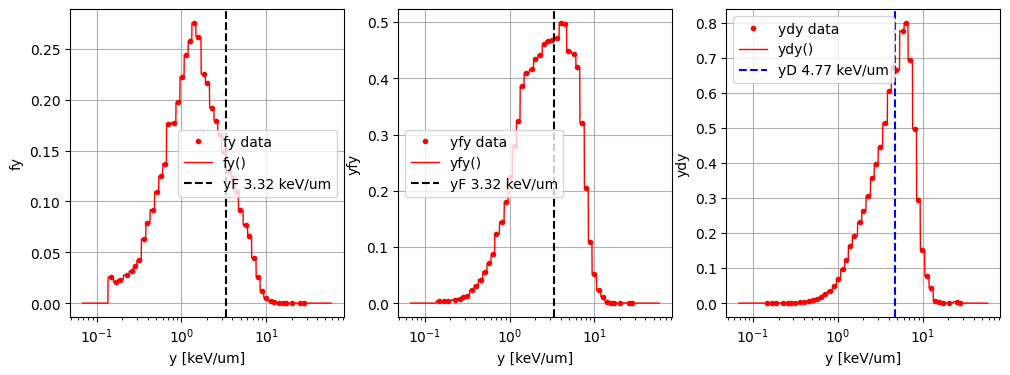

In [31]:
xvalues = np.geomspace(start=spectrum_clipped.data.bin_edges[0]/2, stop=spectrum_clipped.data.bin_edges[-1]*2, num=1000)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].plot(spectrum_clipped.y, spectrum_clipped.fy, '.', label='fy data', color='r')
ax[0].plot(xvalues, spectrum_clipped.data.bin_values(xvalues, spectrum_value_type=SpectrumValueType.fy), label='fy()', linestyle='-', linewidth=1, color='r')
ax[0].axvline(spectrum_clipped.yF, color='k', linestyle='--', label=f'yF {spectrum_clipped.yF:2.2f} keV/um')
ax[0].set_ylabel('fy')
ax[1].plot(spectrum_clipped.y, spectrum_clipped.yfy, '.', label='yfy data', color='r')
ax[1].plot(xvalues, spectrum_clipped.data.bin_values(xvalues, spectrum_value_type=SpectrumValueType.yfy), label='yfy()', linestyle='-', linewidth=1, color='r')
ax[1].axvline(spectrum_clipped.yF, color='k', linestyle='--', label=f'yF {spectrum_clipped.yF:2.2f} keV/um')
ax[1].set_ylabel('yfy')
ax[2].plot(spectrum_clipped.y, spectrum_clipped.ydy, '.', label='ydy data', color='r')
ax[2].plot(xvalues, spectrum_clipped.data.bin_values(xvalues, spectrum_value_type=SpectrumValueType.ydy), label='ydy()', linestyle='-', linewidth=1, color='r')
ax[2].axvline(spectrum_clipped.yD, color='b', linestyle='--', label=f'yD {spectrum_clipped.yD:2.2f} keV/um')
ax[2].set_ylabel('ydy')
for a in ax:
    a.set_xscale('log')
    a.grid()
    a.set_xlabel('y [keV/um]')
    a.legend()

## Folding

In [32]:
# we apply convolution on f(y), not on yfy or ydy
f1_function = lambda x : spectrum_clipped.data.bin_value(x, spectrum_value_type=SpectrumValueType.fy) 

expected_f2_domain = (spectrum_clipped.data.bin_edges[0]*2,spectrum_clipped.data.bin_edges[-1]*2.)
xvalues_for_f2 = np.geomspace(start=expected_f2_domain[0], stop=expected_f2_domain[1], num=50)

convolution_integration_limits = (spectrum_clipped.data.bin_edges[0]/2,spectrum_clipped.data.bin_edges[-1]*2)
integral_kwargs = {'limit': 800, 'points': np.geomspace(*convolution_integration_limits,400)}
f2_values_and_errors = [convolution(
    f1_function,
    lower_limit=convolution_integration_limits[0], 
    upper_limit=convolution_integration_limits[1], 
    kwargs=integral_kwargs)(y) for y in xvalues_for_f2]

/home/grzanka/workspace/widma/src/convolution/numerical.py:36: IntegrationWarning: The maximum number of subdivisions (800) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(func=integrand, a=lower_limit, b=upper_limit, args=(y, integrand_args), *args, **kwargs)


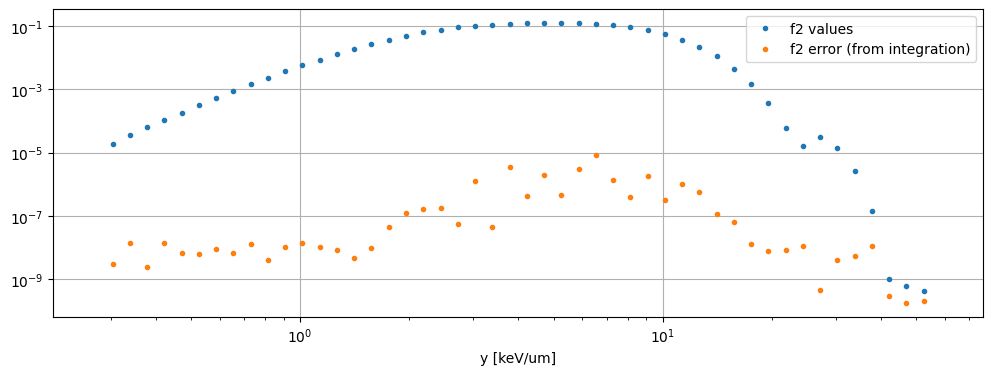

In [33]:
# by comparing the integration error with f2 values we check the numerical integration accuracy
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.plot(xvalues_for_f2, [item[0] for item in f2_values_and_errors], '.', label='f2 values')
ax.plot(xvalues_for_f2, [item[1] for item in f2_values_and_errors], '.', label='f2 error (from integration)')
ax.grid()
ax.set_xlabel('y [keV/um]')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

In [34]:
f2_spectrum = LinealEnergySpectrum(
    data=SpectrumData(
        bin_centers=xvalues_for_f2, 
        bin_values_freq=np.array([item[0] for item in f2_values_and_errors])
        )
    )

In [35]:
f2_spectrum.yF, f2_spectrum.yD

(6.654154427498713, 8.115532443525396)

In [36]:
# check if yF is doubled
f2_spectrum.yF / spectrum_clipped.yF

2.0034668873852466

In [37]:
# check norm
f2_spectrum.norm

0.9889273413145863

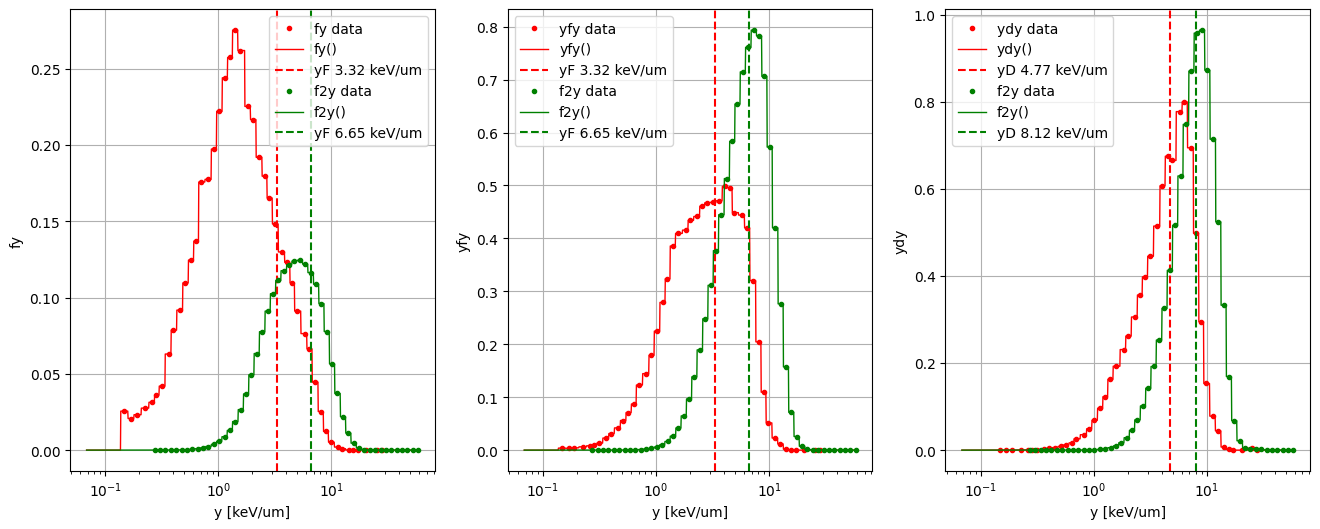

In [38]:
xvalues = np.geomspace(start=spectrum_clipped.data.bin_edges[0]/2, stop=spectrum_clipped.data.bin_edges[-1]*2, num=1000)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].plot(spectrum_clipped.y, spectrum_clipped.fy, '.', label='fy data', color='r')
ax[0].plot(xvalues, spectrum_clipped.data.bin_values(xvalues, spectrum_value_type=SpectrumValueType.fy), label='fy()', linestyle='-', linewidth=1, color='r')
ax[0].axvline(spectrum_clipped.yF, color='r', linestyle='--', label=f'yF {spectrum_clipped.yF:2.2f} keV/um')
ax[0].plot(f2_spectrum.y, f2_spectrum.fy, '.', label='f2y data', color='g')
ax[0].plot(xvalues, f2_spectrum.data.bin_values(xvalues, spectrum_value_type=SpectrumValueType.fy), label='f2y()', linestyle='-', linewidth=1, color='g')
ax[0].axvline(f2_spectrum.yF, color='g', linestyle='--', label=f'yF {f2_spectrum.yF:2.2f} keV/um')
ax[0].set_ylabel('fy')
ax[1].plot(spectrum_clipped.y, spectrum_clipped.yfy, '.', label='yfy data', color='r')
ax[1].plot(xvalues, spectrum_clipped.data.bin_values(xvalues, spectrum_value_type=SpectrumValueType.yfy), label='yfy()', linestyle='-', linewidth=1, color='r')
ax[1].axvline(spectrum_clipped.yF, color='r', linestyle='--', label=f'yF {spectrum_clipped.yF:2.2f} keV/um')
ax[1].plot(f2_spectrum.y, f2_spectrum.yfy, '.', label='f2y data', color='g')
ax[1].plot(xvalues, f2_spectrum.data.bin_values(xvalues, spectrum_value_type=SpectrumValueType.yfy), label='f2y()', linestyle='-', linewidth=1, color='g')
ax[1].axvline(f2_spectrum.yF, color='g', linestyle='--', label=f'yF {f2_spectrum.yF:2.2f} keV/um')
ax[1].set_ylabel('yfy')
ax[2].plot(spectrum_clipped.y, spectrum_clipped.ydy, '.', label='ydy data', color='r')
ax[2].plot(xvalues, spectrum_clipped.data.bin_values(xvalues, spectrum_value_type=SpectrumValueType.ydy), label='ydy()', linestyle='-', linewidth=1, color='r')
ax[2].axvline(spectrum_clipped.yD, color='r', linestyle='--', label=f'yD {spectrum_clipped.yD:2.2f} keV/um')
ax[2].plot(f2_spectrum.y, f2_spectrum.ydy, '.', label='f2y data', color='g')
ax[2].plot(xvalues, f2_spectrum.data.bin_values(xvalues, spectrum_value_type=SpectrumValueType.ydy), label='f2y()', linestyle='-', linewidth=1, color='g')
ax[2].axvline(f2_spectrum.yD, color='g', linestyle='--', label=f'yD {f2_spectrum.yD:2.2f} keV/um')
ax[2].set_ylabel('ydy')
for a in ax:
    a.set_xscale('log')
    #a.set_yscale('log')
    a.grid()
    a.set_xlabel('y [keV/um]')
    a.legend()